In [19]:
import torch
import numpy as np


def rayleigh_channel_filtered_gaussian(fmT, Omgp=1, sample_num=3000, device="cpu"):
    """
    Generate the in-phase and quadrature components of a Rayleigh fading channel with filtered Gaussian noise.

    Parameters:
    - fmT: The normalized Doppler frequency, fmT = f_m * T.
    - Omgp: The power spectral density of the Gaussian noise source.
    - sample_num: The number of samples to generate.
    - device: The device (CPU or GPU) where the tensors should be located.

    Returns:
    - gI: The in-phase component of the Rayleigh fading channel.
    - gQ: The quadrature component of the Rayleigh fading channel.
    """
    sigma = (
        2
        - torch.cos(torch.tensor(np.pi * fmT / 2))
        - torch.sqrt((2 - torch.cos(torch.tensor(np.pi * fmT / 2))) ** 2 - 1)
    ).to(device)

    var = (1 + sigma) / (1 - sigma) * Omgp / 2

    # Generate two independent white Gaussian noise sources for Gi and Gq
    w1 = torch.normal(0, torch.sqrt(var), size=(sample_num,), device=device)
    w2 = torch.normal(0, torch.sqrt(var), size=(sample_num,), device=device)

    # Initialize the in-phase (Gi) and quadrature (Gq) output arrays
    gI = torch.zeros(sample_num, device=device)
    gQ = torch.zeros(sample_num, device=device)
    gI[0] = 1  # Initial condition
    gQ[0] = 1  # Initial condition

    # Apply the first-order lowpass filter to generate Gi and Gq
    for j in range(1, sample_num):
        gI[j] = sigma * gI[j - 1] + (1 - sigma) * w1[j - 1]
        gQ[j] = sigma * gQ[j - 1] + (1 - sigma) * w2[j - 1]

    return gI, gQ


def rayleigh_channel_sum_of_sinusoids(fmT, M, T=1, sample_num=3000):
    """
    Generate the in-phase and quadrature components of a Rayleigh fading channel using the sum of sinusoids method, implemented with PyTorch.

    Parameters:
    - fmT: The normalized Doppler frequency, fmT = f_m * T.
    - M: The number of sinusoids to use in the sum.
    - T: The symbol period.
    - sample_num: The number of samples to generate.

    Returns:
    - gI: The in-phase component of the Rayleigh fading channel.
    - gQ: The quadrature component of the Rayleigh fading channel.
    """

    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu"
    )  # Automatically use GPU if available

    fm = torch.tensor(fmT / T, device=device)
    m = torch.arange(1, M + 1, device=device)
    N = 4 * M + 2
    n = torch.arange(1, N + 1, device=device)
    theta_n = 2 * torch.pi * n / N  # theta_n is uniformly distributed
    theta_m = theta_n[:M]
    beta_m = torch.pi * m / M
    alpha = torch.tensor(0.0, device=device)

    # Calculate the Doppler shifts for different angles
    fn = fm * torch.cos(theta_m).unsqueeze(0)  # Using broadcasting instead of outer

    gI = torch.zeros(sample_num + 1, device=device)
    gQ = torch.zeros(sample_num + 1, device=device)

    # Calculate gI and gQ using sum of sinusoids
    for t in range(sample_num + 1):
        t_tensor = torch.tensor(t, device=device)  # Convert t to a tensor
        cos_component = torch.cos(2 * torch.pi * t_tensor * fn)
        gI[t] = 2 * torch.sum(torch.cos(beta_m) * cos_component) + torch.sqrt(
            torch.tensor(2.0, device=device)
        ) * torch.cos(alpha) * torch.cos(2 * torch.pi * fm * t_tensor)
        gQ[t] = 2 * torch.sum(torch.sin(beta_m) * cos_component) + torch.sqrt(
            torch.tensor(2.0, device=device)
        ) * torch.sin(alpha) * torch.cos(2 * torch.pi * fm * t_tensor)

    return gI, gQ

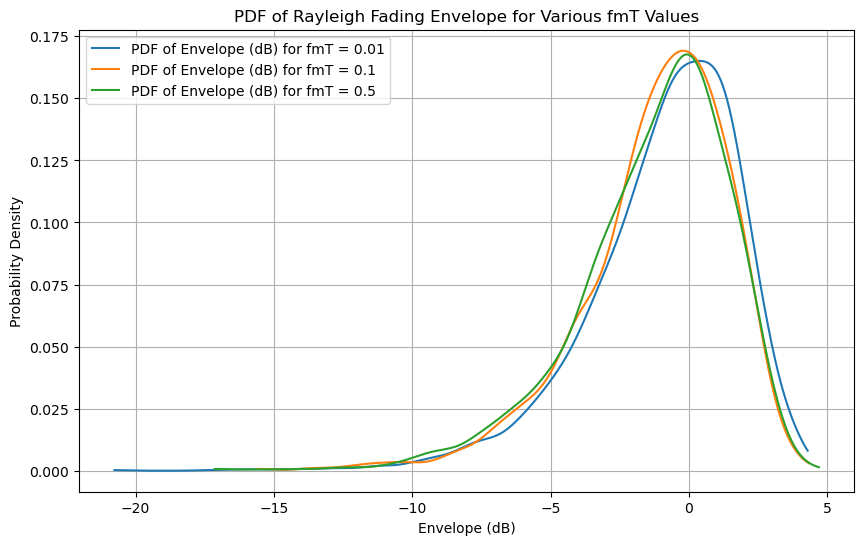

In [20]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Example usage for different fmT values
fmTs = [0.01, 0.1, 0.5]
plt.figure(figsize=(10, 6))  # Specify the size of the figure
for fmT in fmTs:
    gI, gQ = rayleigh_channel_filtered_gaussian(fmT)
    envelope = np.sqrt(gI**2 + gQ**2)
    envelope_dB = 10 * np.log10(envelope)
    density = gaussian_kde(envelope_dB)
    x = np.linspace(min(envelope_dB), max(envelope_dB), 1000)
    pdf = density(x)
    plt.plot(x, pdf, label=f"PDF of Envelope (dB) for fmT = {fmT}")

plt.title("PDF of Rayleigh Fading Envelope for Various fmT Values")
plt.xlabel("Envelope (dB)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

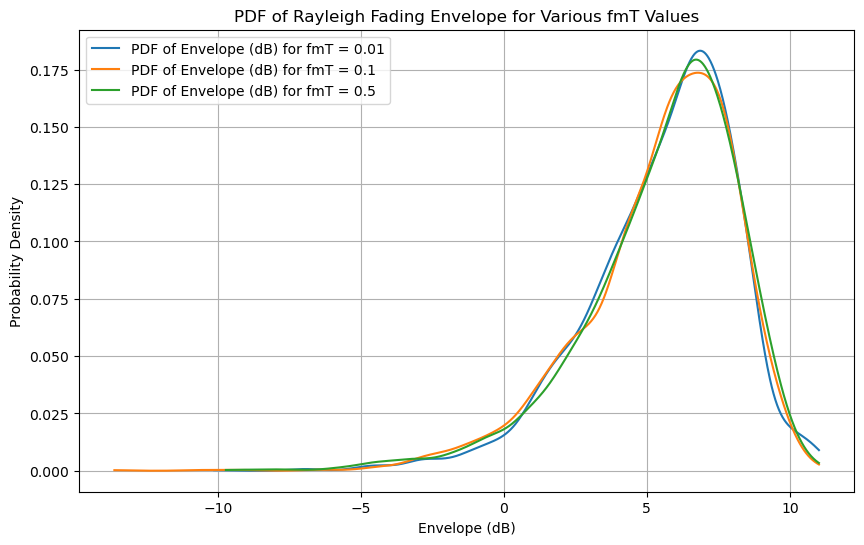

In [21]:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Example usage for different fmT values
fmTs = [0.01, 0.1, 0.5]
plt.figure(figsize=(10, 6))  # Specify the size of the figure
for fmT in fmTs:
    gI, gQ = rayleigh_channel_sum_of_sinusoids(fmT, 10)
    envelope = np.sqrt(gI**2 + gQ**2)
    envelope_dB = 10 * np.log10(envelope)
    density = gaussian_kde(envelope_dB)
    x = np.linspace(min(envelope_dB), max(envelope_dB), 1000)
    pdf = density(x)
    plt.plot(x, pdf, label=f"PDF of Envelope (dB) for fmT = {fmT}")

plt.title("PDF of Rayleigh Fading Envelope for Various fmT Values")
plt.xlabel("Envelope (dB)")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

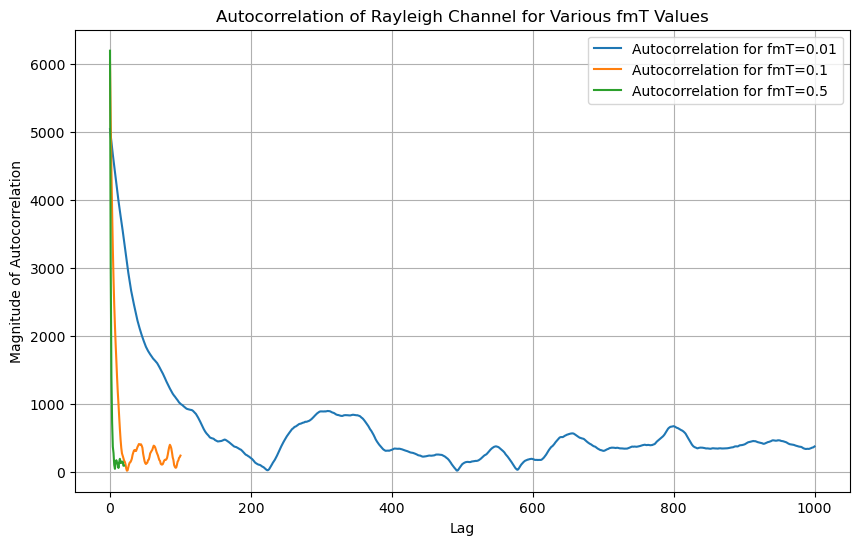

In [22]:
# Example usage for different fmT values
fmTs = [0.01, 0.1, 0.5]
T = 1  # symbol period

plt.figure(figsize=(10, 6))  # Create a single figure for all plots
for fmT in fmTs:
    fm = fmT / T
    tau = int(10 / fm)  # Largest tau, satisfying fm*tau=0~10

    gI, gQ = rayleigh_channel_filtered_gaussian(fmT)
    g = np.sqrt(2) * (gI + 1j * gQ)  # Form the complex channel signal

    # Compute full autocorrelation and extract half (as autocorrelation is symmetrical)
    full_ac = np.correlate(g, g, mode="full")
    half_ac = full_ac[len(full_ac) // 2 : len(full_ac) // 2 + tau + 1]

    # Add plot for current fmT
    plt.plot(np.abs(half_ac), label=f"Autocorrelation for fmT={fmT}")

plt.title("Autocorrelation of Rayleigh Channel for Various fmT Values")
plt.xlabel("Lag")
plt.ylabel("Magnitude of Autocorrelation")
plt.legend()
plt.grid(True)
plt.show()

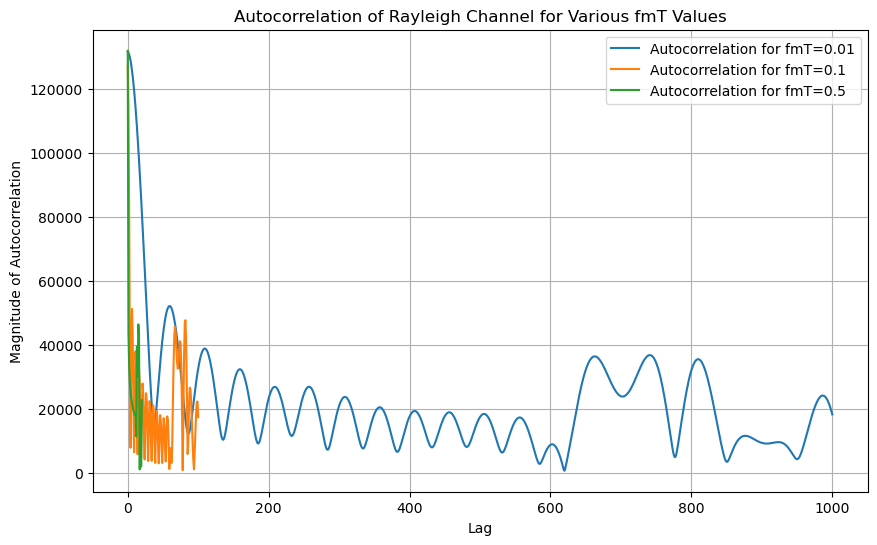

In [23]:
# Example usage for different fmT values
fmTs = [0.01, 0.1, 0.5]
T = 1  # symbol period

plt.figure(figsize=(10, 6))  # Create a single figure for all plots
for fmT in fmTs:
    fm = fmT / T
    tau = int(10 / fm)  # Largest tau, satisfying fm*tau=0~10

    gI, gQ = rayleigh_channel_sum_of_sinusoids(fmT, 10)
    g = np.sqrt(2) * (gI + 1j * gQ)  # Form the complex channel signal

    # Compute full autocorrelation and extract half (as autocorrelation is symmetrical)
    full_ac = np.correlate(g, g, mode="full")
    half_ac = full_ac[len(full_ac) // 2 : len(full_ac) // 2 + tau + 1]

    # Add plot for current fmT
    plt.plot(np.abs(half_ac), label=f"Autocorrelation for fmT={fmT}")

plt.title("Autocorrelation of Rayleigh Channel for Various fmT Values")
plt.xlabel("Lag")
plt.ylabel("Magnitude of Autocorrelation")
plt.legend()
plt.grid(True)
plt.show()